# Estimating Causal Effect of Graduate Education on Income

Based on Shawhin Talebi's work:

https://github.com/ShawhinT/YouTube-Blog/blob/main/causality/causal_inference/causal_inference_example.ipynb

Data from: 

https://archive.ics.uci.edu/ml/datasets/census+income

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle
import econml
import dowhy
from dowhy import CausalModel

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define column names from the 'adult.names' file
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 
    'marital-status', 'occupation', 'relationship', 'race', 
    'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
    'native-country', 'income'
]

# Load the training data
df_train = pd.read_csv('data/adult.data',                 # Path to adult.data
                       names=columns,                # Set column names
                       sep=r',\s*',                  # Raw string for regex separator
                       engine='python')              # Required for regex in separator

# Load the test data (skip the first line which is a header comment)
df_test = pd.read_csv('data/adult.test',                  # Path to adult.test
                      names=columns,                 # Set column names
                      skiprows=1,                    # Skip the first line
                      sep=r',\s*',                   # Raw string for regex separator
                      engine='python')               # Required for regex in separator

# Clean whitespace in string columns
df_train = df_train.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_test = df_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Clean trailing periods from income column in test set
df_test['income'] = df_test['income'].str.replace('.', '', regex=False)

# Optional: display the first few rows
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Concatenate the two DataFrames
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Optional: show the shape and preview
print(f"Combined shape: {df_all.shape}")
df_all.head()

Combined shape: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df_all.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K
48841,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K


In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
df_all['education'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [9]:
# Define the graduate degrees
grad_degrees = ['Masters', 'Doctorate', 'Prof-school']

# Create the new column with 1 if education is in grad_degrees, else 0
df_all['hasGraduateDegree'] = df_all['education'].isin(grad_degrees).astype(int)

# Optional: check result
df_all.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,hasGraduateDegree
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [10]:
df_all['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [11]:
# Create a new column: 1 if income is '>50K', else 0
df_all['greaterThan50k'] = (df_all['income'] == '>50K').astype(int)

# Optional: check result
df_all.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,hasGraduateDegree,greaterThan50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0,0


## 1 - Create Causal Model

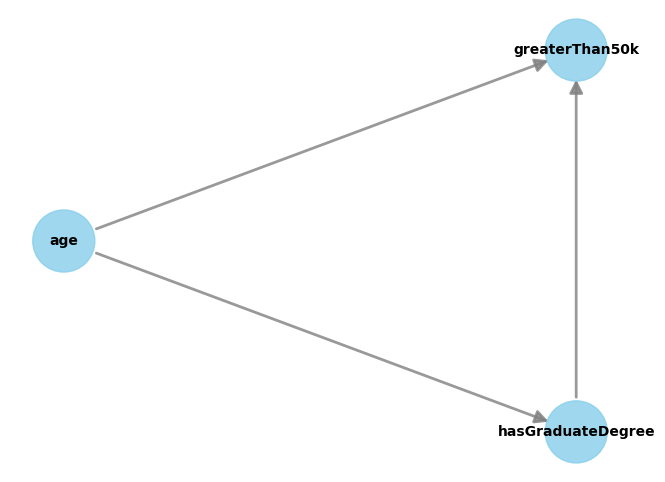

In [12]:
# Create model
model=CausalModel(
        data = df_all,
        treatment= "hasGraduateDegree",
        outcome= "greaterThan50k",
        common_causes="age",
        )

# View model
model.view_model()

* T = treatment (1 if has graduate degree, 0 otherwise)

* Y = outcome (greaterThan50k → 1 if income > $50K)

* X = observed covariates (like age)

## 2 - Identify effect

In [13]:
# Identify effect
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## 3 - Estimate effect

In [14]:
# Identify the estimand
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model.estimate_effect(identified_estimand_experiment,
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.2695024904647359
Effect estimates: [[0.38010211]
 [0.36686351]
 [0.38779632]
 ...
 [0.38779632]
 [0.31810153]
 [0.46567674]]



    On average, having a graduate degree increases the probability of earning more than $50K by ~26.9 percentage points, holding age constant.

    0.36801641: For this individual, having a graduate degree increases the probability of earning >$50K by ~36.8 percentage points.
    ...
    0.45932799: For another individual, the effect is ~45.9 percentage points.

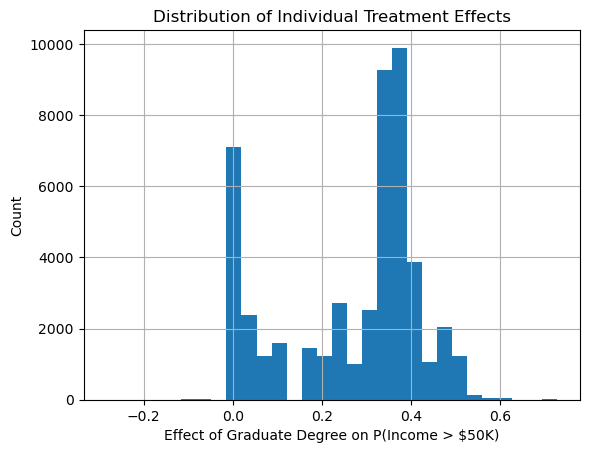

In [15]:
effects = metalearner_estimate.cate_estimates

plt.hist(effects, bins=30)
plt.title("Distribution of Individual Treatment Effects")
plt.xlabel("Effect of Graduate Degree on P(Income > $50K)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

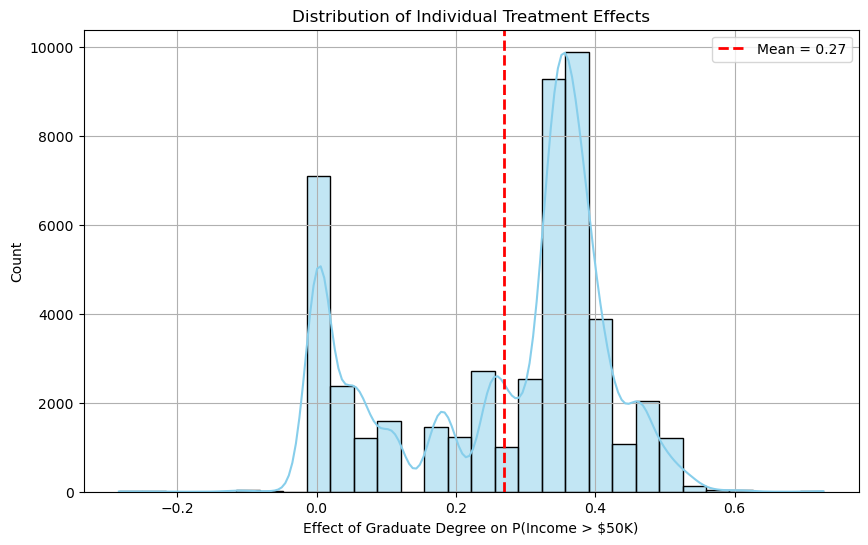

In [16]:
# Flatten effects if necessary (e.g., shape (n, 1))
effects = np.ravel(metalearner_estimate.cate_estimates)

# Calculate the mean effect
mean_effect = effects.mean()

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(effects, bins=30, kde=True, color='skyblue', edgecolor='black')

# Add red dashed line for the mean
plt.axvline(mean_effect, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_effect:.2f}')

# Customize plot
plt.title("Distribution of Individual Treatment Effects")
plt.xlabel("Effect of Graduate Degree on P(Income > $50K)")
plt.ylabel("Count")
plt.grid(True)
plt.legend()

# Show plot
plt.show()

In [17]:
effects

array([0.38010211, 0.36686351, 0.38779632, ..., 0.38779632, 0.31810153,
       0.46567674])

### Subgroups who benefit the most

In [18]:
# Subgroups who benefit the most

df_all['treatment_effect'] = effects

top10 = df_all.sort_values('treatment_effect', ascending=False).head(10)
top10

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,hasGraduateDegree,greaterThan50k,treatment_effect
12492,82,?,52921,Some-college,10,Widowed,?,Not-in-family,Amer-Indian-Eskimo,Male,0,0,3,United-States,<=50K,0,0,0.727671
20421,82,Private,147729,5th-6th,3,Widowed,Other-service,Unmarried,White,Male,0,0,20,United-States,<=50K,0,0,0.727671
32494,82,?,403910,HS-grad,9,Never-married,?,Not-in-family,White,Male,0,0,3,United-States,<=50K,0,0,0.727671
45586,82,Self-emp-not-inc,121944,7th-8th,4,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K,0,0,0.727671
31855,82,Self-emp-not-inc,71438,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,20,United-States,<=50K,0,0,0.727671
19180,82,?,42435,10th,6,Widowed,?,Not-in-family,White,Male,0,0,20,United-States,<=50K,0,0,0.727671
39476,82,Self-emp-not-inc,181912,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,12,United-States,<=50K,0,0,0.727671
33959,82,Self-emp-inc,220667,7th-8th,4,Widowed,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K,0,0,0.727671
24280,82,Self-emp-inc,130329,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,0,0.727671
22481,82,Self-emp-inc,120408,Some-college,10,Widowed,Sales,Not-in-family,White,Male,0,0,20,United-States,<=50K,0,0,0.727671


    If these individuals had a graduate degree (instead of not having one), their predicted probability of earning more than $50K would increase by 76.1 percentage points.

## 4 - Refute effect

1. Randomly shuffles the hasGraduateDegree values across the data.

2. Re-estimates the causal effect using this placebo treatment.

3. Compares it to your real effect.

In [19]:
refute_placebo_treatment = model.refute_estimate(     # Run placebo test to assess robustness
    identified_estimand_experiment,                   # Use the correct estimand object
    metalearner_estimate,                             # Use the estimated causal effect
    method_name="placebo_treatment_refuter",          # Specify placebo refuter method
    placebo_type="permute"                            # Permute treatment values to simulate random placebo
)
print(refute_placebo_treatment)                       # Print the results

Refute: Use a Placebo Treatment
Estimated effect:0.2695024904647359
New effect:-0.0007490072754389146
p value:0.94



* Having a graduate degree increases the probability of earning >$50K by ~26.8%.

* -0.0007 — when we randomly shuffled the treatment (hasGraduateDegree), the model found no effect.
    
* 0.94 — very high, meaning the placebo estimate is statistically indistinguishable from 0.

The true effect (0.2678) is substantially different from the placebo effect (~0). This implies your estimate is not due to chance or noise. A high p-value (close to 1) here is good — it confirms that the placebo estimate is not significant.

    Our causal estimate appears valid and robust. The treatment (hasGraduateDegree) has a real positive effect on the outcome (greaterThan50k), and this is not an artifact of random data structure.